# Annotation Tutorial

**NB**: please refer to the scVI-dev notebook for introduction of the scVI package.

In this notebook, we investigate how semi-supervised learning combined with the probabilistic modelling of latent variables in scVI can help address the annotation problem.

The annotation problem consists in labelling cells, ie. **inferring their cell types**, knowing only a part of the labels.

In [2]:
cd ../..
%matplotlib inline

#### Loading Config

In [3]:
save_path = 'data/'
n_epochs_all = None

{'save_path': 'data/'}


In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, LoomDataset
from scvi.models import SCANVI, VAE
from scvi.inference import UnsupervisedTrainer, JointSemiSupervisedTrainer, SemiSupervisedTrainer

## Annotating one dataset from another


#### Synthetic data

We perform the annotation task on synthetically generated data:

In [5]:
if not os.path.exists(os.path.join(save_path, 'simulation/')):
    os.makedirs(os.path.join(save_path, 'simulation/'))

In [6]:
simulation_1 = LoomDataset(filename='simulation_1.loom',
                           save_path=os.path.join(save_path, 'simulation/'),
                           url='https://github.com/YosefLab/scVI-data/raw/master/simulation/simulation_1.loom')

scanvi = SCANVI(simulation_1.nb_genes, simulation_1.n_batches, simulation_1.n_labels)
trainer_scanvi = SemiSupervisedTrainer(scanvi, simulation_1, frequency=5)

File data/simulation/simulation_1.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset


#### Introductory example

In the semi-supervised setting, we first need to define the labelled and unlabelled set. These are each represented in as the `Posterior` attributes of `trainer` object, called `labelled_set` and `unlabelled_set`.

To override these attributes, the method `.create_posterior()` of the trainer might take the indices of interest.

In the scenario of annotating one dataset from another, we can set those indices according to the biological batch index, which determines the origin of the dataset. In the example below, we try to predict cell-types of batch 1 given cell-types of batch 0.

In [7]:
n_epochs = 200 if n_epochs_all is None else n_epochs_all
trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=(simulation_1.batch_indices == 0).ravel())
trainer_scanvi.labelled_set.to_monitor = ['reconstruction_error', 'accuracy']
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=(simulation_1.batch_indices == 1).ravel())
trainer_scanvi.unlabelled_set.to_monitor = ['reconstruction_error', 'accuracy']

trainer_scanvi.train(n_epochs)

training: 100%|██████████| 200/200 [10:19<00:00,  3.10s/it]


We plot the evolution of the accuracy throughout the training.

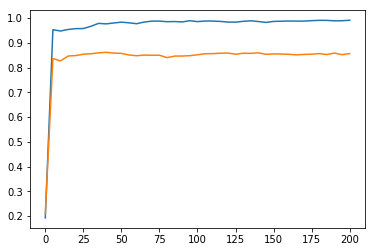

In [9]:
accuracy_labelled_set = trainer_scanvi.history["accuracy_labelled_set"]
accuracy_unlabelled_set = trainer_scanvi.history["accuracy_unlabelled_set"]
x = np.linspace(0,n_epochs,(len(accuracy_labelled_set)))
plt.plot(x, accuracy_labelled_set, label="accuracy labelled")
plt.plot(x, accuracy_unlabelled_set, label="accuracy unlabelled")

We can evaluate the final accuracy of SCANVI's classifier:

In [11]:
print("Labelled set accuracy : ", trainer_scanvi.labelled_set.accuracy())
print("Unlabelled set accuracy : ", trainer_scanvi.unlabelled_set.accuracy())

Labelled set accuracy :  0.9912017596480703
Unlabelled set accuracy :  0.8565713142628526


As well as the Nearest Neighbors predictor accuracy in SCANVI's latent space:

In [10]:
print("NN accuracy in latent space : ", trainer_scanvi.labelled_set.nn_latentspace(trainer_scanvi.unlabelled_set))

NN accuracy in latent space :  0.8550710142028406


To get the predictions, `.compute_predictions()` returns the original (ground truth) and predicted labels. In the case where the second dataset actually came with no cell-type labelling at all, the first argument is just an array of "dummy" labels.

In [12]:
_, y_pred = trainer_scanvi.unlabelled_set.compute_predictions()

The tsne for both datasets can be visualized with the `.full_dataset` Posterior attribute of the `trainer`.

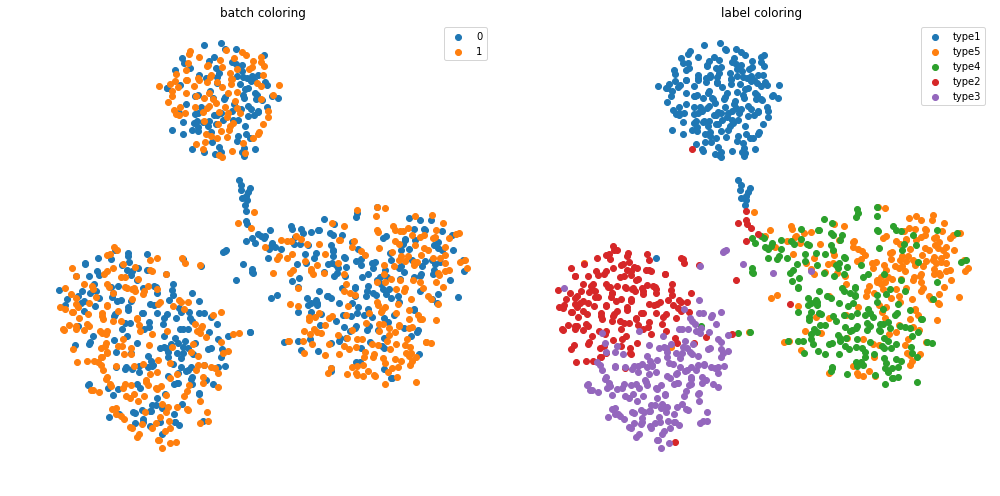

In [13]:
n_samples_tsne = 1000
trainer_scanvi.full_dataset.show_t_sne(n_samples=n_samples_tsne, color_by='batches and labels')

In [14]:
trainer_scanvi.full_dataset.entropy_batch_mixing()

0.6549233317434594

In [15]:
n_samples = 100
M_permutation = 10000
bayes_factors_list = trainer_scanvi.full_dataset.differential_expression_score(
    simulation_1.labels.ravel()==0 , simulation_1.labels.ravel() == 4, 
    n_samples=n_samples, M_permutation=M_permutation
)

### Going further

For benchmarking, let's wrap it all into a function. We might use VAE model before for pretraining.

In [16]:
n_epochs_vae = 150 if n_epochs_all is None else n_epochs_all
n_epochs_scanvi = 50 if n_epochs_all is None else n_epochs_all
n_samples_tsne = 1000 


def scanvi_both_ways(dataset):
    print("Unsupervised training: warm-up phase using only the VAE.")
    vae = VAE(dataset.nb_genes, dataset.n_batches, dataset.n_labels)
    trainer = UnsupervisedTrainer(vae, dataset, train_size=1.0)
    trainer.train(n_epochs_vae)
    print("Entropy batch mixing : ", trainer.train_set.entropy_batch_mixing())
    trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='batches and labels')

    for i in [0,1]:
        print("\nUsing batch %d as labelled set"%i)
        scanvi = SCANVI(dataset.nb_genes, dataset.n_batches, dataset.n_labels,
                        classifier_parameters = {'dropout_rate':0.2, 'n_hidden':256, 'n_layers':2})
        scanvi.load_state_dict(vae.state_dict(), strict=False)

        trainer_scanvi = SemiSupervisedTrainer(scanvi, dataset)
        trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=(dataset.batch_indices==i).ravel())
        trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=(dataset.batch_indices==1-i).ravel())

        print("VAE + KNN classifier: ", trainer_scanvi.labelled_set.nn_latentspace(trainer_scanvi.unlabelled_set))
        trainer_scanvi.train(n_epochs_scanvi, lr=1e-4)
        accuracy_score = trainer_scanvi.unlabelled_set.accuracy()
        print("Unlabelled set accuracy : ", trainer_scanvi.unlabelled_set.accuracy())

Unsupervised training: warm-up phase using only the VAE.
training: 100%|██████████| 150/150 [03:35<00:00,  1.44s/it]
Entropy batch mixing :  0.6809642631445477

Using batch 0 as labelled set
VAE + KNN classifier:  0.7864572914582917
training: 100%|██████████| 50/50 [02:36<00:00,  3.12s/it]
Unlabelled set accuracy :  0.865373074614923

Using batch 1 as labelled set
VAE + KNN classifier:  0.7859428114377125
training: 100%|██████████| 50/50 [02:35<00:00,  3.10s/it]
Unlabelled set accuracy :  0.8614277144571085


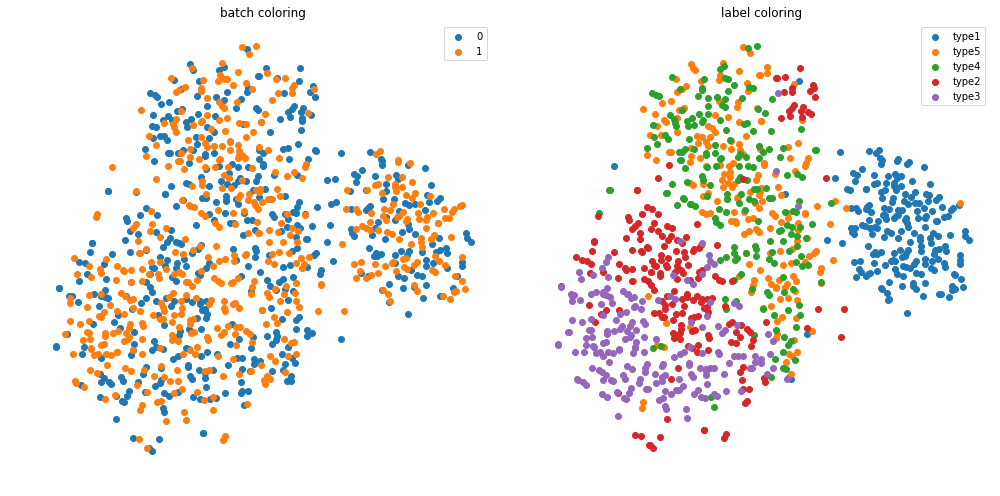

In [17]:
scanvi_both_ways(simulation_1)

#### UMI / Non UMI simulation

In this simulation, batch 0 is UMI counts whereas batch 1 is non UMI.

File data/simulation/simulation_2.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
Unsupervised training: warm-up phase using only the VAE.
training: 100%|██████████| 150/150 [07:16<00:00,  2.91s/it]
Entropy batch mixing :  0.3207725656572789

Using batch 0 as labelled set
VAE + KNN classifier:  0.70805
training: 100%|██████████| 50/50 [05:14<00:00,  6.29s/it]
Unlabelled set accuracy :  0.81775

Using batch 1 as labelled set
VAE + KNN classifier:  0.6577
training: 100%|██████████| 50/50 [05:15<00:00,  6.31s/it]
Unlabelled set accuracy :  0.8072


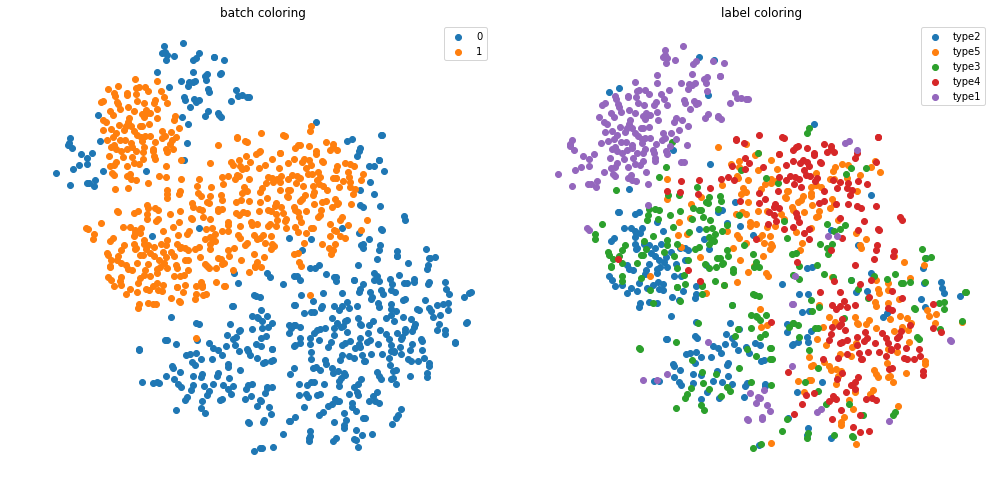

In [18]:
simulation_2 = LoomDataset(filename='simulation_2.loom',
                           save_path=os.path.join(save_path, 'simulation/'),
                           url='https://github.com/YosefLab/scVI-data/raw/master/simulation/simulation_2.loom')

scanvi_both_ways(simulation_2)

#### EVF / not EVF

File data/simulation/simulation_3.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
Unsupervised training: warm-up phase using only the VAE.
training: 100%|██████████| 150/150 [03:45<00:00,  1.50s/it]
Entropy batch mixing :  0.6767414956695009

Using batch 0 as labelled set
VAE + KNN classifier:  0.6743
training: 100%|██████████| 50/50 [02:36<00:00,  3.12s/it]
Unlabelled set accuracy :  0.7444

Using batch 1 as labelled set
VAE + KNN classifier:  0.6794
training: 100%|██████████| 50/50 [02:36<00:00,  3.13s/it]
Unlabelled set accuracy :  0.7593


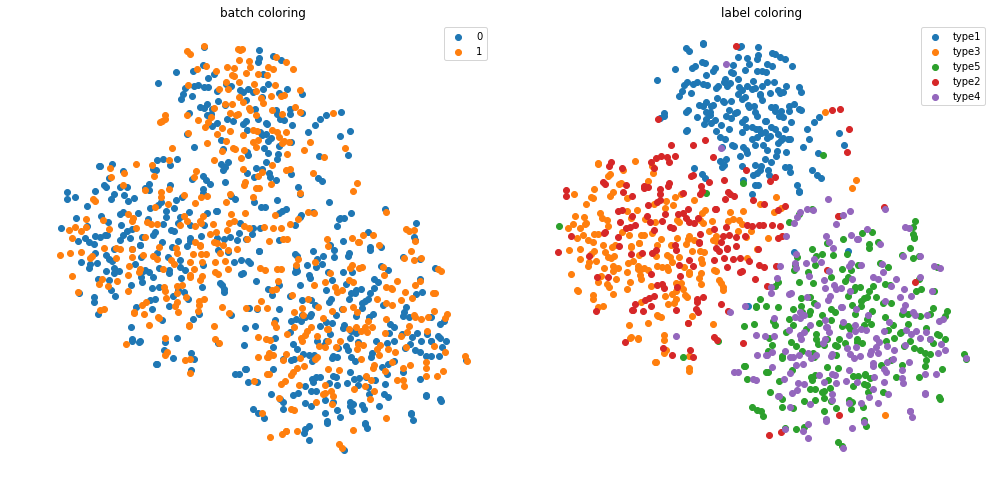

In [19]:
simulation_3 = LoomDataset(filename='simulation_3.loom',
                           save_path=os.path.join(save_path, 'simulation/'),
                           url='https://github.com/YosefLab/scVI-data/raw/master/simulation/simulation_3.loom')

scanvi_both_ways(simulation_3)

We instantiate the `SCANVI` model and train it over 250 epochs. Only labels from the `data_loader_labelled` will be used, but to cross validate the results, the labels of `data_loader_unlabelled` will is used at test time. The accuracy of the `unlabelled` dataset reaches 93% here at the end of training.

## Annotating a dataset with few labels

SCANVI also performs well in the context of annotating the rest of a dataset.

In [5]:
gene_dataset = CortexDataset(save_path=save_path, total_genes=558)

use_batches=False
use_cuda=True

n_epochs = 100 if n_epochs_all is None else n_epochs_all
n_cl = 10
scanvi = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels)
trainer = JointSemiSupervisedTrainer(scanvi, gene_dataset, 
                                     n_labelled_samples_per_class=n_cl, 
                                     classification_ratio=100)
trainer.train(n_epochs=n_epochs)

trainer.unlabelled_set.accuracy()

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data
training: 100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


0.9260647359454856

**Benchmarking against other algorithms**

We can compare ourselves against the random forest and SVM algorithms, where we do grid search with 3-fold cross validation to find the best hyperparameters of these algorithms. This is automatically performed through the functions **`compute_accuracy_svc`** and **`compute_accuracy_rf`**.

These functions should be given as input the numpy array corresponding to the equivalent dataloaders, which is the purpose of the **`get_raw_data`** method from `scvi.dataset.utils`.

The format of the result is an Accuracy named tuple object giving higher granularity information about the accuracy ie, with attributes:

- **unweighted**: the standard definition of accuracy

- **weighted**: we might give the same weight to all classes in the final accuracy results. Informative only if the dataset is unbalanced.

- **worst**: the worst accuracy score for the classes

- **accuracy_classes** : give the detail of the accuracy per classes


Compute the accuracy score for rf and svc

In [6]:
from scvi.inference.annotation import compute_accuracy_rf, compute_accuracy_svc

data_train, labels_train = trainer.labelled_set.raw_data()
data_test, labels_test = trainer.unlabelled_set.raw_data()
svc_scores = compute_accuracy_svc(data_train, labels_train, data_test, labels_test)
rf_scores = compute_accuracy_rf(data_train, labels_train, data_test, labels_test)

print("\nSVC score test :\n", svc_scores[0][1])
print("\nRF score train :\n", rf_scores[0][1])

/home/romain/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/romain/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/romain/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



SVC score test :
 Accuracy(unweighted=0.8701873935264055, weighted=0.8465908861701248, worst=0.7223650385604113, accuracy_classes=[0.794392523364486, 0.9066666666666666, 0.8857142857142857, 0.7954545454545454, 0.9345679012345679, 0.8869752421959096, 0.7223650385604113])

RF score train :
 Accuracy(unweighted=0.8933560477001703, weighted=0.874333009653023, worst=0.6503856041131105, accuracy_classes=[0.883177570093458, 0.8977777777777778, 0.9964285714285714, 0.8181818181818182, 0.9604938271604938, 0.9138858988159311, 0.6503856041131105])


/home/romain/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
def allow_notebook_for_test():
    print("Testing the annotation notebook")